In [21]:
import random
import networkx as nx
import matplotlib.pyplot as plt
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import NetworkGrid

Notes:

The research question could be refined to focus on studying information diffusion within our social media simulation model. The model currently simulates social media usage, allowing us to investigate how varying engagement (e.g., changing engagement from a uniform distribution U(0,1) to other distributions like normal, or altering ranges such as U(0,0.5) or U(0.5,1)) influences information diffusion. We will measure information diffusion by analyzing path lengths between nodes and the engagement values associated with edges, providing insights into how different engagement dynamics affect the spread of information across the network.

To better reflect real-life dynamics, we can consider allowing multiple connections to form simultaneously to reach equilibrium, instead of the current model where the network eventually dies out (which is specifically modelled to get insight into the network decay). This can be adjusted easily. Additionally, consider removing the requirement that a new connection replaces an old one with low engagement, or introduce a probability for this condition. Real-world social media interactions often include diverse engagement levels, not solely high engagement connections.

Let $G$ be the directed graph, and $E(u, v)$ be the engagement value of the edge from node $u$ to node $v$.

1. **Engagement Similarity** for each node $i$:
    - Calculate the average engagement for incoming edges:
      $$
      \bar{E}_i = \frac{1}{\text{deg}^- (i)} \sum_{(u, i) \in G} E(u, i)
      $$
    - Calculate similarity for each edge $(u, i)$:
      $$
      S(u, i) = 1 - \left| E(u, i) - \bar{E}_i \right|
      $$
    - Average similarity for node $i$:
      $$
      S_i = \frac{1}{\text{deg}^- (i)} \sum_{(u, i) \in G} S(u, i)
      $$

2. **Overall Homogeneity Index**:
    - Average similarity across all nodes with more than one incoming edge:
      $$
      H = \frac{1}{N} \sum_{i \in V, \text{deg}^- (i) > 1} S_i
      $$
      where $N$ is the number of nodes with $\text{deg}^- (i) > 1$.

This gives the homogeneity index based on engagement similarity.


In [68]:
class SocialNetworkAgent(Agent):
    """Agent class models agent behavior individually"""
    def __init__(self, unique_id, model, interaction, option):
        super().__init__(unique_id, model)
        self.engagement_threshold = random.uniform(0, 1)
        self.interaction = interaction
        self.option = option

    def step(self):
        self.agent_behavior()

    def agent_behavior(self):
        """Follower behavior called each iteration for follower agents"""
        if self.interaction == "random":
            neighbors = list(self.model.G.neighbors(self.unique_id))
            if neighbors:
                target = random.choice(neighbors)
                if random.random() < self.engagement_threshold:
                    self.model.add_directed_connection(self.unique_id, target)

        elif self.interaction == "extended":
            self.extended_interaction()

    def targeted_recommendation(self):
        """Calculate targeted recommendation based on engagement similarity and shortest path length"""
        G = self.model.G
        follower_node = self.unique_id

        # Calculate recommendation scores
        recommendation_scores = {}
        for influencer_node in G.nodes():
            if influencer_node != follower_node:
                try:
                    shortest_path_length = nx.shortest_path_length(G, source=follower_node, target=influencer_node)
                except nx.NetworkXNoPath:
                    continue  # Skip this influencer if no path exists

                follower_engagements = [G[neighbor][follower_node]['engagement'] for neighbor in G.predecessors(follower_node)]
                influencer_engagements = [G[neighbor][influencer_node]['engagement'] for neighbor in G.predecessors(influencer_node)]
                
                # Calculate homogeneity over follower vs influencer
                if follower_engagements and influencer_engagements:
                    mean_follower_engagement = sum(follower_engagements) / len(follower_engagements)
                    mean_influencer_engagement = sum(influencer_engagements) / len(influencer_engagements)
                    homogeneity = 1 - abs(mean_follower_engagement - mean_influencer_engagement)

                    # Use a combination of shortest_path_length and homogeneity for recommendation score
                    recommendation_score = shortest_path_length * homogeneity
                    recommendation_scores[influencer_node] = recommendation_score

        # Normalize recommendation scores
        total_score = sum(recommendation_scores.values())
        normalized_scores = {k: v / total_score for k, v in recommendation_scores.items()} if total_score > 0 else {}

        if normalized_scores:
            chosen_influencer = random.choices(list(normalized_scores.keys()), weights=list(normalized_scores.values()), k=1)
        else:
            chosen_influencer = None

        return chosen_influencer

    def extended_interaction(self):
        """Choose interaction algorithm"""
        if self.option == 1:
            self.make_directional_connection()
        elif self.option == 2:
            self.ask_for_recommendation_with_random_loss()
        elif self.option == 3:
            self.ask_for_recommendation_with_certain_loss()

    def make_directional_connection(self):
        """Makes connection with neighbor of neighbor node if not yet present"""
        neighbors = list(self.model.G.neighbors(self.unique_id))
        potential_targets = set()
        for neighbor in neighbors:
            potential_targets.update(self.model.G.neighbors(neighbor))

        potential_targets = list(potential_targets)
        if potential_targets:
            target = random.choice(potential_targets)
            if not self.model.G.has_edge(self.unique_id, target):
                self.model.add_directed_connection(self.unique_id, target)
            else:
                self.connect_to_random_node()
        else:
            self.connect_to_random_node()
            
    def connect_to_random_node(self):
        """Connects node to random node"""
        possible_targets = [node for node in self.model.G.nodes if node != self.unique_id]
        target = random.choice(possible_targets)
        if not self.model.G.has_edge(self.unique_id, target):
            self.model.add_directed_connection(self.unique_id, target)

    def ask_for_recommendation_with_certain_loss(self):
        """Requests a recommendation and updates connections with certain loss.

        Chooses an influencer based on a recommendation score. If an influencer is chosen
        and the agent has incoming edges, replaces existing connections with the influencer
        if the new recommendation offers higher engagement. """
        
        chosen_influencer = self.targeted_recommendation()
        if chosen_influencer:
            chosen_influencer = chosen_influencer[0]
            in_edges = list(self.model.G.in_edges(self.unique_id, data=True))
            if in_edges:
                for edge in in_edges:
                    if self.model.G.has_edge(chosen_influencer, self.unique_id):
                        if edge[2]['engagement'] < self.model.G[chosen_influencer][self.unique_id]['engagement']:
                            self.model.G.remove_edge(edge[0], self.unique_id)
                            self.model.G.add_edge(chosen_influencer, self.unique_id, engagement=random.random())
                            break


    def ask_for_recommendation_with_random_loss(self):
        """Requests a recommendation and updates connections with random loss.
        
        Chooses an influencer based on a recommendation score. If an influencer is chosen
        and the agent has incoming edges, replaces the edge with the lowest engagement
        with a new connection to the influencer with a random engagement value."""
        
        chosen_influencer = self.targeted_recommendation()
        if chosen_influencer:
            chosen_influencer = chosen_influencer[0]
            in_edges = list(self.model.G.in_edges(self.unique_id, data=True))
            if in_edges:
                lowest_engagement_edge = min(in_edges, key=lambda x: x[2]['engagement'])
                if random.random() < self.engagement_threshold:
                    self.model.G.remove_edge(lowest_engagement_edge[0], self.unique_id)
                    self.model.G.add_edge(chosen_influencer, self.unique_id, engagement=random.random())


class SocialNetworkModel(Model):
    """Social network model class models the interaction between agents"""
    def __init__(self, num_agents, initial_p, interaction="random", option=1):
        super().__init__()
        self.num_agents = num_agents
        self.schedule = RandomActivation(self)
        self.initial_p = initial_p

        self.create_random_network()
        
        # Check if graph is strongy connected, if not take the strongly connected part and use as total
        if not nx.is_strongly_connected(self.G):
            components = list(nx.strongly_connected_components(self.G))
            largest_component = max(components, key=len)
            self.G = self.G.subgraph(largest_component).copy()
        
        # Initialize grid using mesa.space.NetworkGrid
        self.grid = NetworkGrid(self.G)
        
        # Add agents in each node, note each agent has node=unique_id
        for i, node in enumerate(self.G.nodes()):
            agent = SocialNetworkAgent(node, self, interaction, option)
            self.schedule.add(agent)
            self.grid.place_agent(agent, node)
            self.G.nodes[node]['agent'] = agent  # Store the agent in the node attributes
            

        self.data_collector = {"avg_out_degree": [], "avg_in_degree": [],
                               "avg_clustering_coeff": [], "avg_path_length": [],
                               "homogeneity": []}

    def create_random_network(self):
        """Initiate random network with bi-directed edges including 
        random engagement value U(0,1)"""
        self.G = nx.DiGraph()
        undirected_G = nx.erdos_renyi_graph(n=self.num_agents, p=self.initial_p)
        for u, v in undirected_G.edges():
            # Add directed edges when initializing graph, engagement value in each direction
            self.G.add_edge(u, v, engagement=random.random())
            self.G.add_edge(v, u, engagement=random.random())

    def add_directed_connection(self, from_node, to_node):
        """Add directed connections between nodes"""
        if not self.G.has_edge(from_node, to_node):
            self.G.add_edge(from_node, to_node, engagement=random.random())

    def get_mean_in_degree(self):
        """Calculate the mean in-degree of network"""
        degrees = [val for (node, val) in self.G.in_degree()]
        mean_degree = sum(degrees) / len(degrees)
        return mean_degree

    def step(self):
        """Steps in the simulation"""
        if not nx.is_strongly_connected(self.G):
            components = list(nx.strongly_connected_components(self.G))
            largest_component = max(components, key=len)
            removed_nodes = set(self.G.nodes()) - set(largest_component)
            for node in removed_nodes:
                agent = self.G.nodes[node]['agent']
                self.schedule.remove(agent)
            self.G = self.G.subgraph(largest_component).copy()
        self.track_metrics()    
        self.schedule.step()
        self.prune_network()

    def track_metrics(self):
        """Tracking metrics over network"""
        avg_out_degree = sum(dict(self.G.out_degree()).values()) / self.num_agents
        avg_in_degree = sum(dict(self.G.in_degree()).values()) / self.num_agents
        avg_clustering_coeff = nx.average_clustering(self.G)
        avg_path_length = nx.average_shortest_path_length(self.G)
        homogeneity = self.calculate_homogeneity()

        self.data_collector["avg_out_degree"].append(avg_out_degree)
        self.data_collector["avg_in_degree"].append(avg_in_degree)
        self.data_collector["avg_clustering_coeff"].append(avg_clustering_coeff)
        self.data_collector["avg_path_length"].append(avg_path_length)
        self.data_collector["homogeneity"].append(homogeneity)

    def calculate_homogeneity(self):
        """Calculates homogeneity based on engagement similarity over network"""
        total_similarity = 0
        count = 0
        for node in self.G.nodes():
            engagement_values = [self.G[neighbor][node]['engagement'] for neighbor in self.G.predecessors(node)]
            if len(engagement_values) > 1:
                mean_engagement = sum(engagement_values) / len(engagement_values)
                similarity = sum([1 - abs(engagement - mean_engagement) for engagement in engagement_values]) / len(engagement_values)
                total_similarity += similarity
                count += 1
        return total_similarity / count if count > 0 else 0

    def prune_network(self):
        """Prunes network by modulo of number of agents 
        (if pruned by a percentage, network dies out very soon)"""
        edges = list(self.G.edges())
        num_edges_to_remove = len(edges) // self.num_agents
        edges_to_remove = random.sample(edges, num_edges_to_remove)
        self.G.remove_edges_from(edges_to_remove)


In [71]:
# Running the model
model = SocialNetworkModel(num_agents=100, initial_p=0.5, interaction="extended", option=1)
for i in range(500):
    model.step()
    pos = nx.spring_layout(model.G)
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

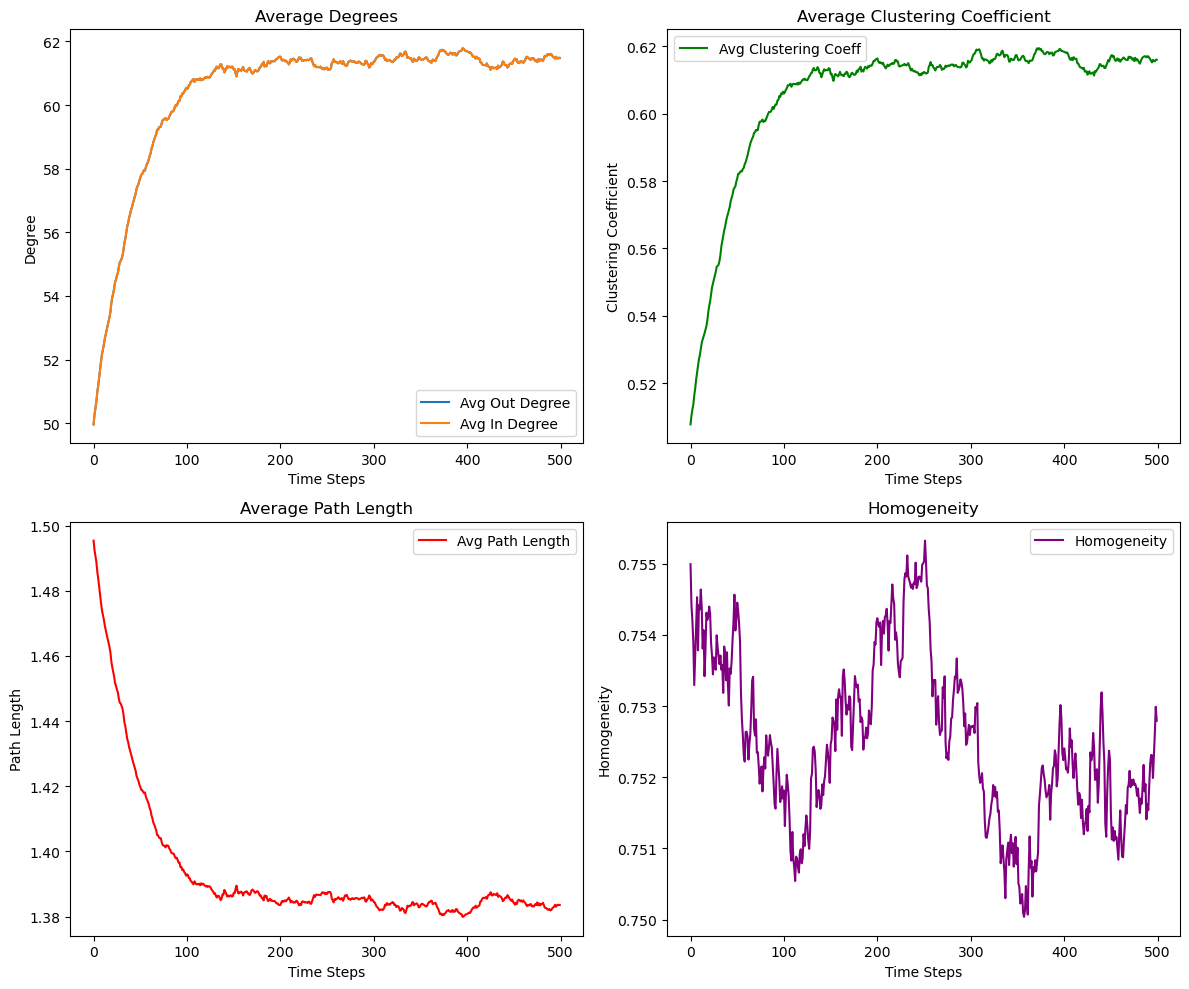

In [72]:
import matplotlib.pyplot as plt

# Create a figure with 4 subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Plot Avg Out Degree and Avg In Degree together in the first subplot
axs[0, 0].plot(model.data_collector["avg_out_degree"], label="Avg Out Degree")
axs[0, 0].plot(model.data_collector["avg_in_degree"], label="Avg In Degree")
axs[0, 0].set_title("Average Degrees")
axs[0, 0].set_xlabel("Time Steps")
axs[0, 0].set_ylabel("Degree")
axs[0, 0].legend()

# Plot Avg Clustering Coefficient in the second subplot
axs[0, 1].plot(model.data_collector["avg_clustering_coeff"], label="Avg Clustering Coeff", color='green')
axs[0, 1].set_title("Average Clustering Coefficient")
axs[0, 1].set_xlabel("Time Steps")
axs[0, 1].set_ylabel("Clustering Coefficient")
axs[0, 1].legend()

# Plot Avg Path Length in the third subplot
axs[1, 0].plot(model.data_collector["avg_path_length"], label="Avg Path Length", color='red')
axs[1, 0].set_title("Average Path Length")
axs[1, 0].set_xlabel("Time Steps")
axs[1, 0].set_ylabel("Path Length")
axs[1, 0].legend()

# Plot Homogeneity in the fourth subplot
axs[1, 1].plot(model.data_collector["homogeneity"], label="Homogeneity", color='purple')
axs[1, 1].set_title("Homogeneity")
axs[1, 1].set_xlabel("Time Steps")
axs[1, 1].set_ylabel("Homogeneity")
axs[1, 1].legend()

# Adjust the layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()
